In [1]:
# %pip install ipynb
# %pip install face_recognition -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# import notebook
from ipynb.fs.full.facial_similarity_checker import *

# import the necessary packages
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [3]:
# helper function 
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [4]:
def align_images(image, template, maxFeatures=500, keepPercent=0.2,
    debug=False):
    # convert both the input image and template to grayscale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # use ORB to detect keypoints and extract (binary) local
    # invariant features
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)
    
    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)

    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x:x.distance)
    # keep only the top matches
    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]
    
    # check to see if we should visualize the matched keypoints
    if debug:
        matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
            matches, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        plt_imshow("Matched Keypoints", matchedVis)
    
    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for (i, m) in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    print(f"ptsA: {ptsA}")
    print(f"ptsB: {ptsB}")

    # compute the homography matrix between the two sets of matched
    # points
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=5.0)
    print(f"H: {H}")
    
    # use the homography matrix to align the images
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(image, H, (w, h))
    
    # return the aligned image
    return aligned

x: 50	y: 33	Size: (165,165)
x: 325	y: 513	Size: (860,860)
{'verified': False, 'distance': 0.9142792393772782, 'threshold': 0.68, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 50, 'y': 33, 'w': 165, 'h': 165, 'left_eye': (165, 98), 'right_eye': (99, 98)}, 'img2': {'x': 325, 'y': 513, 'w': 860, 'h': 860, 'left_eye': (890, 845), 'right_eye': (758, 1184)}}, 'time': 3.38}
The similarity between the images is:  0.9142792393772782
The images are the same person:  False


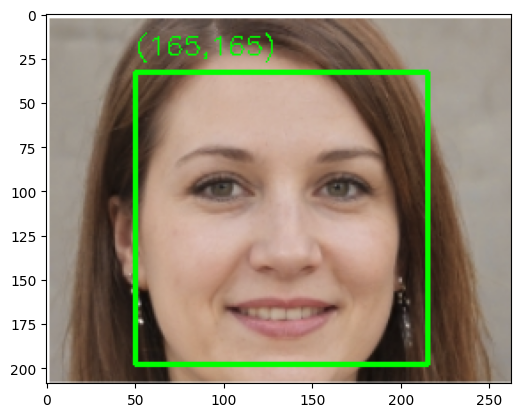

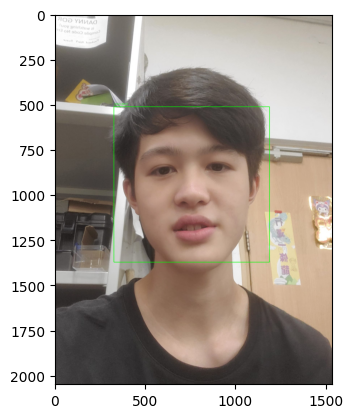

[INFO] loading images...
[INFO] aligning images...


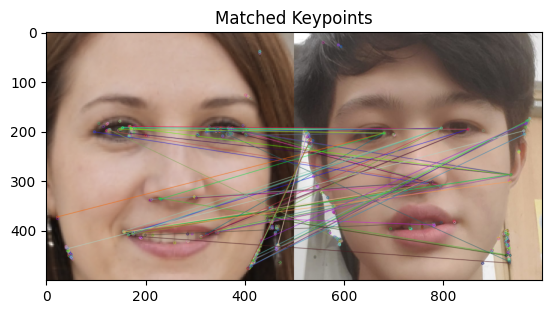

ptsA: [[515.97821045 275.90499878]
 [568.80004883 278.40002441]
 [220.32000732 565.92004395]
 [456.19207764 570.24005127]
 [453.86968994 570.32312012]
 [555.39318848 283.07138062]
 [219.80163574 566.09289551]
 [480.         563.        ]
 [423.01446533 468.63366699]
 [136.16090393 283.07138062]
 [221.184021   565.05603027]
 [480.1463623  562.55957031]
 [482.11206055 565.05603027]
 [240.07318115 275.90499878]
 [418.03787231 465.81362915]
 [459.8416748  268.73864746]
 [244.85075378 564.35113525]
 [175.57591248 279.4881897 ]
 [483.14886475 566.09289551]
 [218.97221375 564.84875488]
 [244.85075378 570.32312012]
 [243.65637207 569.72589111]
 [216.48388672 271.22695923]
 [236.49000549 286.65454102]
 [479.52001953 565.92004395]
 [246.34373474 572.3137207 ]
 [480.74356079 564.35113525]
 [484.80001831 565.20001221]
 [452.87435913 569.82543945]
 [516.57537842 274.71060181]
 [480.24588013 271.22695923]
 [297.40408325 472.98001099]
 [218.57409668 562.55957031]
 [ 32.         522.        ]
 [586.  

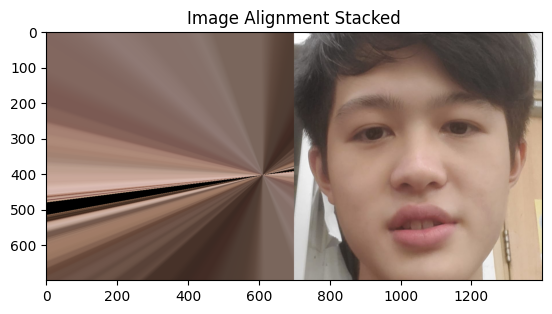

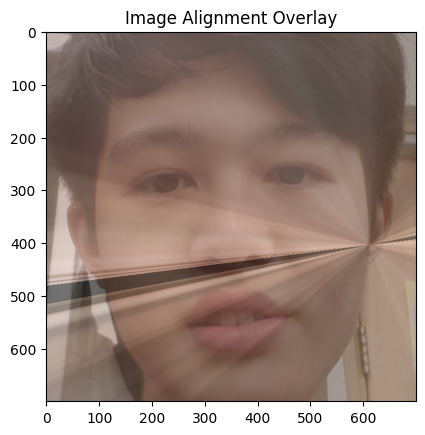

In [5]:
# construct the argument parser and parse the arguments
image1_path = "img/image1.png"
image2_path = "img/me_without_mask4.jpg"

checker = facial_similarity_checker()
checker.load_image(image1_path, image2_path)
checker.show_result(True)

area1, area2 = checker.get_facial_area()

# load the input image and template from disk
print("[INFO] loading images...")
image = cv2.imread(image1_path)
template = cv2.imread(image2_path)

image = image[area1.y:area1.y+area1.height, area1.x:area1.x+area1.width]
template = template[area2.y:area2.y+area2.height, area2.x:area2.x+area2.width]

# resize both the aligned and template images so we can easily
# visualize them on our screen
image = imutils.resize(image, width=700, height=700)
template = imutils.resize(template, width=700, height=700)

# align the images
print("[INFO] aligning images...")
aligned = align_images(image, template, debug=True)

# our first output visualization of the image alignment will be a
# side-by-side comparison of the output aligned image and the
# template
stacked = np.hstack([aligned, template])

# our second image alignment visualization will be *overlaying* the
# aligned image on the template, that way we can obtain an idea of
# how good our image alignment is
overlay = template.copy()
output = aligned.copy()
cv2.addWeighted(overlay, 0.5, output, 0.5, 0, output)

# show the two output image alignment visualizations
plt_imshow("Image Alignment Stacked", stacked)
plt.show()

plt_imshow("Image Alignment Overlay", output)
plt.show()